In [8]:
import pickle
import torch
import numpy as np
import os
import re
import json
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from scipy.linalg import det
from sklearn.manifold import MDS
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
import warnings

In [2]:
def load_pickle(filename: str):
    with open(filename, "rb") as outp:
        obj = pickle.load(outp)
    return obj

In [3]:
def load_json(filename: str) -> dict:
    return json.load(
        open(
            filename,
            "r",
            encoding="utf-8",
        )
    )

# Exploration analysis

Possible questions, fixing delta multiplier and experiment type (in terms of repetitions too):

- How much are we exploring? This has to be studied both generally and fixing the number of explored patches and the type of algorithm
    - delta values at each iteration
    - embedding difference at each iteration

- How much time does experiments take?

TODOS:

- info on dynamic type warping metric
- simec/simexp comparison
- number of patches vs attribution vs delta

In [4]:
experiments_path = "../../res"  # path to exploration results directory
data_path = "../../data"  # path to input data used in experiments

In [5]:
def collect_pkl_res_files(exploration_result_dir: str) -> list:
    """
    Collects paths to all `.pkl` files in a given exploration result directory.

    Parameters:
    ----------
    exploration_result_dir : str
        The root directory to search for `.pkl` files.

    Returns:
    --------
    list
        A list of paths to `.pkl` files found in the directory tree, without considering min and max distribution files.
    """
    pkl_paths = []
    for root, _, files in os.walk(exploration_result_dir):
        # Filter and collect only `.pkl` files
        pkl_paths.extend(
            os.path.join(root, f)
            for f in files
            if f.lower().endswith(".pkl") and "distribution" not in f
        )
    return pkl_paths


def extract_info(file_path: str) -> dict:
    """
    Extracts information from the file path.

    Parameters:
    ----------
    file_path : str
        File path string in the format '../../res/<dataset>-<delta_multiplier>-<extra_number>-<patch_option>-<datetime>/<algorithm>-<input_name>-<repetition>/<iteration>.pkl'

    Returns:
    --------
    dict
        A dictionary with extracted details: dataset, delta_multiplier, patch_option, time, algorithm,
        input_name, repetition, and the datetime object for the timestamp.
    """
    try:
        # Normalize path and split components
        file_path = os.path.normpath(file_path)
        parts = file_path.split(os.sep)

        # Extract the last three components
        iteration_part = parts[-1]
        algorithm_input_repetition_part = parts[-2]
        dataset_part = parts[-3]

        # Parse the iteration part
        iteration = int(iteration_part.split(".")[0])

        # Parse the dataset part
        dataset_info = dataset_part.split("-")
        dataset_name = dataset_info[0]
        delta_multiplier = int(dataset_info[1])
        patch_option = dataset_info[3]
        if "target" in patch_option:
            patch_option = "target-word"
            timestamp_str = dataset_info[5] + "-" + dataset_info[6]
        else:
            timestamp_str = dataset_info[4] + "-" + dataset_info[5]
        timestamp = datetime.strptime(timestamp_str, "%Y%m%d-%H%M%S")

        # Parse the algorithm/input/repetition part
        algorithm, input_name, repetition = algorithm_input_repetition_part.split("-")
        repetition = int(repetition)

        # Return extracted information as a dictionary
        return {
            "dataset_name": dataset_name,
            "delta_multiplier": delta_multiplier,
            "patch_option": patch_option,
            "datetime": timestamp,
            "algorithm": algorithm,
            "input_name": input_name,
            "repetition": repetition,
            "iteration": iteration,
        }
    except Exception as e:
        print(f"Error parsing file path: {file_path}")
        raise ValueError("File path does not match the expected format.") from e


def process_experiment_data(experiments_paths: list, datasets_paths: list):
    # Helper function to process a single experiment file and update the results dictionary
    def extract_pickle_info(file):
        experiment = load_pickle(file)
        experiments["time"].append(experiment.get("time", None))
        experiments["distance"].append(experiment["distance"].detach().numpy())
        experiments["delta"].append(experiment["delta"].detach().numpy().item())
        experiments["input_embedding"].append(
            experiment["input_embedding"].detach().numpy()
        )
        experiments["output_embedding"].append(
            experiment["output_embedding"].detach().numpy()
        )

    def extract_filename_info(file):
        experiment = extract_info(file_path=file)
        for k, v in experiment.items():
            experiments[k].append(v)
        return (
            experiment["input_name"],
            experiment["dataset_name"],
            experiment["patch_option"],
        )

    def collect_attribution(dataset_name: str, input_name: str, patch_option: str):
        for root, _, f in os.walk(datasets_paths):
            if dataset_name == "hatespeech":
                name = "hate-speech"
            elif dataset_name == "winobias":
                name = "wino_bias"
            else:
                name = dataset_name
            if name in root:
                if input_name in [f_n.split(".")[0] for f_n in f]:
                    config = load_json(
                        os.path.join(root, f"config_{patch_option}.json"),
                    )
                    attribution_dict[f"{input_name}-{dataset_name}-{patch_option}"] = (
                        np.array(config[input_name]["attrib"])
                    )
                    return np.array(config[input_name]["attrib"])

    # Initialize dictionary to store experiment results
    experiments = {
        "dataset_name": [],
        "algorithm": [],
        "input_name": [],
        "iteration": [],
        "distance": [],
        "delta": [],
        "delta_multiplier": [],
        "repetition": [],
        "patch_option": [],
        "patch_attribution": [],
        "patches_number": [],
        "input_embedding": [],
        "output_embedding": [],
        "time": [],
        "datetime": [],
    }

    # Initialize dictionary to store attribution for processed instances
    attribution_dict = {}

    # Loop through experiment paths and files, updating the results dictionary
    for file in experiments_paths:
        if "stats" not in file:
            input_name, dataset_name, patch_option = extract_filename_info(file)
            extract_pickle_info(file)
            if patch_option != "target-word":
                attrib = attribution_dict.get(
                    f"{input_name}-{dataset_name}-{patch_option}", None
                )
                if attrib is None:
                    attrib = collect_attribution(
                        dataset_name=dataset_name,
                        input_name=input_name,
                        patch_option=patch_option,
                    )
                experiments["patch_attribution"].append(attrib)
                experiments["patches_number"].append(len(attrib))
            else:
                experiments["patch_attribution"].append(None)
                experiments["patches_number"].append(1)

    # Convert to DataFrame
    return pd.DataFrame.from_dict(experiments)

In [6]:
result_files = collect_pkl_res_files(exploration_result_dir=experiments_path)
experiments_df = process_experiment_data(
    experiments_paths=result_files, datasets_paths=data_path
)

In [13]:
experiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10470 entries, 0 to 10469
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dataset_name       10470 non-null  object        
 1   algorithm          10470 non-null  object        
 2   input_name         10470 non-null  object        
 3   iteration          10470 non-null  int64         
 4   distance           10470 non-null  object        
 5   delta              10470 non-null  float64       
 6   delta_multiplier   10470 non-null  int64         
 7   repetition         10470 non-null  int64         
 8   patch_option       10470 non-null  object        
 9   patch_attribution  10470 non-null  object        
 10  patches_number     10470 non-null  int64         
 11  input_embedding    10470 non-null  object        
 12  output_embedding   10470 non-null  object        
 13  time               10470 non-null  float64       
 14  dateti

In [8]:
experiments_df.head(1)

,dataset_name,algorithm,input_name,iteration,distance,delta,delta_multiplier,repetition,patch_option,patch_attribution,patches_number,input_embedding,output_embedding,time,datetime
0,mnist,simec,img_1599,4000,"[0.014600234, 0.02162446, 0.004195051, 0.01690...",0.009139,1,1,q2,"[0.25685352087020874, 0.25533512234687805, 0.1...",98,"[[[-0.0166088, -0.030268556, 0.037126243, -0.0...","[[[0.73276526, -1.5259124, -2.333797, -5.35444...",0.42028,2025-03-23 05:44:37


## Delta per iteration

Text(0.5, 1.0, 'Delta per iteration')

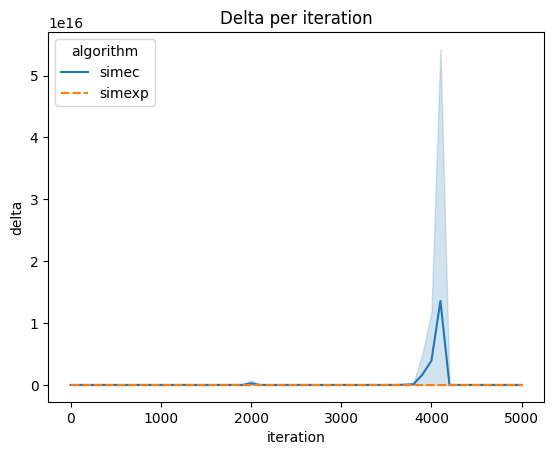

In [12]:
sns.lineplot(
    data=experiments_df,
    x="iteration",
    y="delta",
    style="algorithm",
    hue="algorithm",
).set_title("Delta per iteration")

Deltas could be strange because of capping range and non - normalized input values (especially for images).

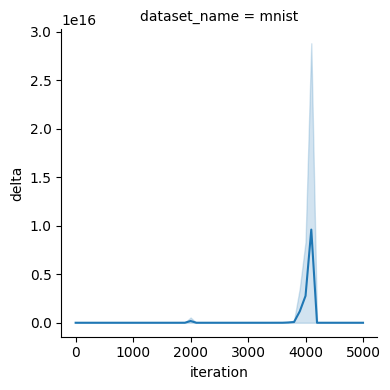

In [10]:
p = sns.FacetGrid(experiments_df, col="dataset_name", sharey=False, height=4, aspect=1)
p.map(
    sns.lineplot,
    "iteration",
    "delta",
)

# Are the explored patches the only one that are really changing?

In [7]:
pkl_paths = []
for root, _, files in os.walk("../experiments_data/mnist_test_20/"):
    # Filter and collect only `.pkl` files
    pkl_paths.extend(
        root
        for f in files
        if "config.json" in  f
    )
configs = []
for config_file in pkl_paths:
    c = load_json(os.path.join(config_file, "config.json"))
    # Normalize path and split components
    file_path = os.path.normpath(config_file)
    parts = file_path.split(os.sep)[-1].split("-")
    dataset = parts[0]
    delta_m = parts[1]
    patch_option = parts[-1]
    for img, img_c in c.items():
        if img_c["explore"] != []:
            configs.append((dataset, delta_m, patch_option, img.split(".")[0], sorted(img_c["explore"])))
        else:
            configs.append((dataset, delta_m, patch_option, img.split(".")[0], list(range(197))))
            
configs = pd.DataFrame(configs, columns=["dataset", "delta", "patch","img","explore"])
grouped = experiments_df.groupby(
    ["input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "dataset_name"]
)
messages = []
for (input_name, algorithm, repetition, delta_multiplier, patch_option, dataset_name), group in grouped:
    if patch_option == "one":
        print()
    # Extract embeddings from the group
    embeddings = np.squeeze(np.stack(group["input_embedding"].values)) # n iterations, n patches, hidden size
    correct_config = configs[(configs["img"] == input_name)&(configs["patch"] == patch_option)&(configs["dataset"] == dataset_name)]["explore"].values[0]
    pat = []
    for patch_id in range(embeddings.shape[1]):
        all_equal = np.all(embeddings[:,patch_id,:] == embeddings[0,patch_id,:], axis = 0).all()
        if not all_equal:
            pat.append(patch_id)
    if len(pat) > len(correct_config):
        print(f"Exploration patches are different from theory to practice for img {input_name} patch option {patch_option} algorithm {algorithm}", len(pat), len(correct_config))
        continue
    wrong = [p for p in pat if p not in correct_config]
    if len(wrong)>0:
        if f"Exploration patches are different from theory to practice for img {input_name} patch option {patch_option} algorithm {algorithm}" not in messages:
            messages.append(f"Exploration patches are different from theory to practice for img {input_name} patch option {patch_option} algorithm {algorithm} diff patches {wrong}")
if len(messages) > 0:
    for m in messages: print(m)
else:
    print("All patches are correct")


All patches are correct


## Exploration Volumes comparison

In [ ]:
grouped = experiments_df.groupby(
    ["input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "dataset_name"]
)

results = []
normal = []

for (input_name, algorithm, repetition, delta_multiplier, patch_option, dataset_name), group in grouped:
    # Extract embeddings from the group
    embeddings = np.stack(group["input_embedding"].values)  # Shape: (N, 1, 197, 64)

    # Compute max and min embeddings across all samples (N)
    max_embedding = np.max(embeddings, axis=0)  # Shape: (1, 197, 64)
    min_embedding = np.min(embeddings, axis=0)  # Shape: (1, 197, 64)

    # Remove extra dimension (squeeze)
    max_embedding = np.squeeze(max_embedding)  # Shape: (197, 64)
    min_embedding = np.squeeze(min_embedding)  # Shape: (197, 64)

    # Compute absolute difference
    sum_patches = np.abs(max_embedding - min_embedding)  # Shape: (197, 64)

    # Compute product across features (last axis)
    patch_volumes = np.prod(sum_patches, axis=-1, dtype=np.float64)  # Shape: (197,)
    
    _, pvalue = normaltest(patch_volumes)
    if pvalue > 0.05:
        normal.append((input_name, algorithm, repetition, delta_multiplier, patch_option, dataset_name))

    # Compute mean and std
    volume_mean = np.mean(patch_volumes)
    volume_std = np.std(patch_volumes)

    # Append results as a tuple (faster than dict)
    results.append((
        dataset_name, input_name, algorithm, repetition, delta_multiplier, patch_option, volume_mean, volume_std
    ))

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=[
    "dataset_name", "input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "volume mean", "volume std"
])

if len(normal) > 0: print(">>>> Some of the volumes distribution are normal")
else: print(">>>> None of the volumes distributions are normal")

df_results

/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1078: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1076: RuntimeWarning: overflow encountered in square
  s = s**2
/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1072: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered 

>>>> None of the volumes distributions are normal


/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


,dataset_name,input_name,algorithm,repetition,delta_multiplier,patch_option,volume mean,volume std
0,mnist,img_1261,simec,1,1,all,4.049344e-77,4.176812e-76
1,mnist,img_1261,simec,2,1,all,1.416342e-76,1.217643e-75
2,mnist,img_1261,simec,3,1,all,1.422974e-77,1.305935e-76
3,mnist,img_1261,simexp,1,1,all,1.348847e-58,1.888386e-57
4,mnist,img_1261,simexp,2,1,all,1.990524e-76,2.786733e-75
...,...,...,...,...,...,...,...,...
202,mnist,img_9628,simec,1,1,q2,1.485135e+99,1.725158e+100
203,mnist,img_9628,simec,2,1,q1,9.635478e+108,7.502227e+109
204,mnist,img_9628,simec,2,1,q2,4.456442e+114,3.229096e+115
205,mnist,img_9628,simec,3,1,q1,6.747317e+129,4.195288e+130


Are explored volumes different across repetitions of the same experiment?

In [17]:
grouped = experiments_df.groupby(
    ["input_name", "algorithm", "delta_multiplier", "patch_option", "dataset_name"]
)

diff_volumes = []

for (input_name, algorithm, delta_multiplier, patch_option, dataset_name), group in grouped:
    
    repetition_groupby = group.groupby(["repetition"])
    
    volumes = []
    
    for (repetition), grep in repetition_groupby: 
    
        # Extract embeddings from the group
        embeddings = np.stack(grep["input_embedding"].values)  # Shape: (N, 1, 197, 64)

        # Compute max and min embeddings across all samples (N)
        max_embedding = np.max(embeddings, axis=0)  # Shape: (1, 197, 64)
        min_embedding = np.min(embeddings, axis=0)  # Shape: (1, 197, 64)

        # Remove extra dimension (squeeze)
        max_embedding = np.squeeze(max_embedding)  # Shape: (197, 64)
        min_embedding = np.squeeze(min_embedding)  # Shape: (197, 64)

        # Compute absolute difference
        sum_patches = np.abs(max_embedding - min_embedding)  # Shape: (197, 64)

        # Compute product across features (last axis)
        volumes.append(np.prod(sum_patches, axis=-1, dtype=np.float64))  # Shape: (197,)
    
    for i in range (len(volumes)):
        for j in range(len(volumes)):
            if i < j:
                _, p_value = mannwhitneyu(volumes[i],  volumes[j], alternative="two-sided")
                if pvalue < 0.05:
                    diff_volumes.append((input_name, algorithm, delta_multiplier, patch_option, dataset_name))

if len(diff_volumes)>0:print(">>>> Some volumes are different")
else: print(">>>> None of the volumes are different")
    

/home/francesco/.pyenv/versions/nips/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


>>>> None of the volumes are different


No volumes across repetitions are different: there is no difference in the quantity of area explored.

Now I want to explore how different are the input embeddings in each repetition of the experiment.

In [21]:
grouped = experiments_df.groupby(
    ["input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "dataset_name"]
)

normal = []

for (input_name, algorithm, repetition, delta_multiplier, patch_option, dataset_name), group in grouped:
    # taking first embedding representing the whole image
    embeddings = np.stack(group["input_embedding"].values)[:,0,0,:]  # Shape: (iterations, hidden_size)
    _, pvalues = normaltest(embeddings, axis = -1)
    if not all(pvalues > 0.05):
        print(">>>> Some of the embeddings are not normal")
        break
    

>>>> Some of the embeddings are not normal


Since I cannot assume normality, I can use mannwhitneyU test to compare embeddings from the same iteration but across different repetitions of the same experiment.

Missing values for repetition 2, input img_2261, algorithm simec, patch_option q2, delta_multiplier 1
Missing values for repetition 2, input img_2261, algorithm simec, patch_option q2, delta_multiplier 1
Missing values for repetition 2, input img_2261, algorithm simec, patch_option q2, delta_multiplier 1
Missing values for repetition 0, input img_5062, algorithm simec, patch_option one, delta_multiplier 1
Missing values for repetition 1, input img_5062, algorithm simec, patch_option one, delta_multiplier 1
Missing values for repetition 2, input img_5062, algorithm simec, patch_option one, delta_multiplier 1
Missing values for repetition 1, input img_821, algorithm simec, patch_option q1, delta_multiplier 1
Missing values for repetition 2, input img_821, algorithm simec, patch_option q1, delta_multiplier 1
Missing values for repetition 1, input img_821, algorithm simec, patch_option q1, delta_multiplier 1
Missing values for repetition 2, input img_821, algorithm simec, patch_option q1, 

Text(0.5, 1.0, 'Mann Whitney U pvalues per iteration')

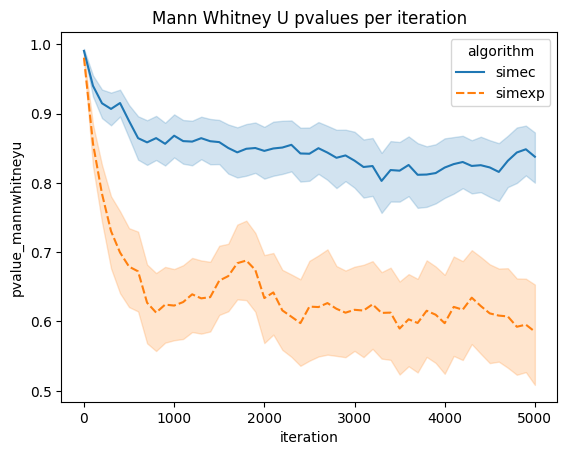

In [113]:
grouped = experiments_df.groupby(
    ["input_name", "algorithm", "delta_multiplier", "patch_option", "dataset_name"]
)

exploration_analysis = {"dataset_name":[], "input_name":[], "algorithm":[], "delta_multiplier":[], "patch_option":[], "iteration":[], "pvalue_mannwhitneyu":[], "stat_mannwhitneyu":[]}

for (input_name, algorithm, delta_multiplier, patch_option, dataset_name), group in grouped:
    repetition_embeddings = np.ones((len(experiments_df["repetition"].unique()), len(experiments_df["iteration"].unique()), experiments_df["input_embedding"].values[0].shape[-1]), dtype=np.float64) * np.inf
    for _, row in group.iterrows():
        repetition_embeddings[row["repetition"]-1, row["iteration"]//100] = row["input_embedding"][0,0] # first 
    for i in range(repetition_embeddings.shape[0]):
        if np.count_nonzero(repetition_embeddings[i]==np.inf) > 0:
            print(f"Missing values for repetition {i}, input {input_name}, algorithm {algorithm}, patch_option {patch_option}, delta_multiplier {delta_multiplier}")
            continue
        for j in range(repetition_embeddings.shape[0]):
            if i < j:
                if np.count_nonzero(repetition_embeddings[j]==np.inf) > 0:
                    print(f"Missing values for repetition {j}, input {input_name}, algorithm {algorithm}, patch_option {patch_option}, delta_multiplier {delta_multiplier}")
                    continue
                stat, pvalues = mannwhitneyu(repetition_embeddings[i], repetition_embeddings[j], alternative = "two-sided", axis = -1)
                for it, (s, p) in enumerate(zip(stat, pvalues)):
                    exploration_analysis["dataset_name"].append(dataset_name)
                    exploration_analysis["input_name"].append(input_name)
                    exploration_analysis["algorithm"].append(algorithm)
                    exploration_analysis["delta_multiplier"].append(delta_multiplier)
                    exploration_analysis["patch_option"].append(patch_option)
                    exploration_analysis["iteration"].append(it * 100)
                    exploration_analysis["pvalue_mannwhitneyu"].append(p)
                    exploration_analysis["stat_mannwhitneyu"].append(s)
exploration_analysis = pd.DataFrame.from_dict(exploration_analysis)
sns.lineplot(
    data=exploration_analysis,
    x="iteration",
    y="pvalue_mannwhitneyu",
    style="algorithm",
    hue="algorithm",
).set_title("Mann Whitney U pvalues per iteration")

Here I have computed how different embeddings coming from different repetitions of the same experiment are at each iteration.

In simec, it is possible to see that embeddings are indeed becoming less and less equal across repetitions as iterations go by. However, this effect is particularly noticeable in the first iterations of simexp, where different repetitions of the same experiment produce even more different embeddings.

Now I want to see the increase in explored volume iteration by iteration.

In [ ]:
grouped = experiments_df[experiments_df["patch_option"] == "all"].groupby(
    ["input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "dataset_name"]
)
results = []
for (input_name, algorithm, repetition, delta_multiplier, patch_option, dataset_name), group in grouped:
    embeddings = np.ones((len(group["iteration"].unique()), group["input_embedding"].values[0].shape[-2], group["input_embedding"].values[0].shape[-1]), dtype=np.float64) * np.inf
    for _, row in group.iterrows():
        embeddings[row["iteration"]//100] = np.squeeze(row["input_embedding"])
    explored_volume = np.zeros((group["input_embedding"].values[0].shape[-2],), dtype=np.float64)
    warn = False
    for i, iteration in enumerate(embeddings):
        if np.count_nonzero(iteration==np.inf) == 0 and not warn:
            if i>0:
                #ridurre a dimensione di rango (svd) reduce svd
                for patch_id in range(embeddings.shape[1]):
                    rank = np.linalg.matrix_rank(embeddings[:i,patch_id,:])
                    svd = TruncatedSVD(n_components=rank)
                    svd_emb = svd.fit_transform(embeddings[:i,patch_id,:])
                
                max_embedding = np.max(embeddings[:i], axis=0)  # Shape: (patches, hidden size)
                min_embedding = np.min(embeddings[:i], axis=0)  # Shape: (patches, hidden size)
                if np.array_equal(max_embedding, min_embedding):
                    for patch_id in range(iteration.shape[0]):
                        results.append((
                            dataset_name, input_name, algorithm, repetition, delta_multiplier, patch_option, i*100, patch_id, explored_volume[patch_id]
                        ))
                else:
                    with warnings.catch_warnings(record=True) as w:
                        warnings.simplefilter("always", RuntimeWarning)  # Force warnings to be caught
                        # Compute absolute difference
                        sum_patches = np.abs(max_embedding - min_embedding) # Shape: (patches, hidden size)
                        # Compute product across features (last axis)
                        patch_volumes = np.prod(sum_patches, axis=-1, dtype=np.float64)  # Shape: (patches,)
                        if w:
                            for warning in w:
                                if issubclass(warning.category, RuntimeWarning):
                                    print(f"Input: {input_name}, Algorithm {algorithm}, Repetition {repetition}, Patch Option {patch_option}. RuntimeWarning: {warning.message}")
                            warn = True
                        else:
                            # Append results as a tuple (faster than dict)
                            for patch_id in range(patch_volumes.shape[0]):
                                explored_volume[patch_id] += np.log(patch_volumes[patch_id])
                                results.append((
                                    dataset_name, input_name, algorithm, repetition, delta_multiplier, patch_option, i*100, patch_id, explored_volume[patch_id]
                                ))

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=[
    "dataset_name", "input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "iteration", "patch_id", "additional_patch_volume"
])

df_results

,dataset_name,input_name,algorithm,repetition,delta_multiplier,patch_option,iteration,patch_id,additional_patch_volume
0,mnist,img_1261,simec,1,1,all,100,0,0.000000
1,mnist,img_1261,simec,1,1,all,100,1,0.000000
2,mnist,img_1261,simec,1,1,all,100,2,0.000000
3,mnist,img_1261,simec,1,1,all,100,3,0.000000
4,mnist,img_1261,simec,1,1,all,100,4,0.000000
...,...,...,...,...,...,...,...,...,...
1181995,mnist,img_9584,simexp,3,1,all,5000,192,-9807.716094
1181996,mnist,img_9584,simexp,3,1,all,5000,193,-9726.909960
1181997,mnist,img_9584,simexp,3,1,all,5000,194,-9686.861745
1181998,mnist,img_9584,simexp,3,1,all,5000,195,-9696.787698


In [15]:
grouped = experiments_df.groupby(
    ["input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "dataset_name"]
)
results = []
for (input_name, algorithm, repetition, delta_multiplier, patch_option, dataset_name), group in grouped:
    print(f"Input: {input_name}, Algorithm {algorithm}, Repetition {repetition}, Patch Option {patch_option}")
    embeddings = np.ones((len(group["iteration"].unique()), group["input_embedding"].values[0].shape[-2], group["input_embedding"].values[0].shape[-1]), dtype=np.float64) * np.inf
    for _, row in group.iterrows():
        embeddings[row["iteration"]//100] = np.squeeze(row["input_embedding"])
    explored_volume = np.zeros((group["input_embedding"].values[0].shape[-2],), dtype=np.float64)
    warn = False
    for i, iteration in enumerate(embeddings):
        if np.count_nonzero(iteration==np.inf) == 0 and not warn:
            if i>1:
                #ridurre a dimensione di rango (svd) reduce svd
                for patch_id in range(embeddings.shape[1]):
                    with warnings.catch_warnings(record=True) as w:
                        warnings.simplefilter("always", RuntimeWarning)
                        rank = np.linalg.matrix_rank(embeddings[:i,patch_id,:])
                        svd = TruncatedSVD(n_components=rank)
                        svd_emb = svd.fit_transform(embeddings[:i,patch_id,:])
                        max_embedding = np.max(svd_emb, axis=0)  # Shape: (patches, hidden size)
                        min_embedding = np.min(svd_emb, axis=0)  # Shape: (patches, hidden size)
                        diff = np.abs(max_embedding - min_embedding)
                        patch_volume = np.prod(diff, axis=-1)
                        if w:
                            for warning in w:
                                if issubclass(warning.category, RuntimeWarning):
                                    print(f"RuntimeWarning: {warning.message}")
                            warn = True
                        else:
                            results.append((
                                        dataset_name, input_name, algorithm, repetition, delta_multiplier, patch_option, i*100, patch_id, patch_volume
                                    ))
                
# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=[
    "dataset_name", "input_name", "algorithm", "repetition", "delta_multiplier", "patch_option", "iteration", "patch_id", "additional_patch_volume"
])

df_results

Input: img_1261, Algorithm simec, Repetition 1, Patch Option all
Input: img_1261, Algorithm simec, Repetition 2, Patch Option all
Input: img_1261, Algorithm simec, Repetition 3, Patch Option all
Input: img_1261, Algorithm simexp, Repetition 1, Patch Option all
Input: img_1261, Algorithm simexp, Repetition 2, Patch Option all
Input: img_1261, Algorithm simexp, Repetition 3, Patch Option all
Input: img_1397, Algorithm simec, Repetition 1, Patch Option q1
Input: img_1397, Algorithm simec, Repetition 2, Patch Option q1
Input: img_1397, Algorithm simec, Repetition 3, Patch Option q1
Input: img_1505, Algorithm simec, Repetition 1, Patch Option all
Input: img_1505, Algorithm simec, Repetition 2, Patch Option all
Input: img_1505, Algorithm simec, Repetition 3, Patch Option all
Input: img_1505, Algorithm simexp, Repetition 1, Patch Option all
Input: img_1505, Algorithm simexp, Repetition 2, Patch Option all
Input: img_1505, Algorithm simexp, Repetition 3, Patch Option all
Input: img_1599, Algor

,dataset_name,input_name,algorithm,repetition,delta_multiplier,patch_option,iteration,patch_id,additional_patch_volume
0,mnist,img_1261,simec,1,1,all,200,0,0.000643
1,mnist,img_1261,simec,1,1,all,200,1,0.000077
2,mnist,img_1261,simec,1,1,all,200,2,0.000087
3,mnist,img_1261,simec,1,1,all,200,3,0.000085
4,mnist,img_1261,simec,1,1,all,200,4,0.000201
...,...,...,...,...,...,...,...,...,...
595287,mnist,img_9628,simec,3,1,q2,200,186,0.001071
595288,mnist,img_9628,simec,3,1,q2,200,188,0.001970
595289,mnist,img_9628,simec,3,1,q2,200,190,0.002914
595290,mnist,img_9628,simec,3,1,q2,200,191,0.002109


Text(0.5, 1.0, 'Additional volume explored per iteration')

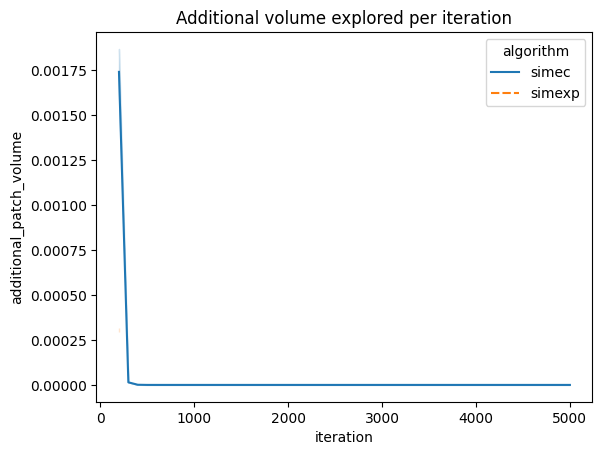

In [16]:
sns.lineplot(
    data=df_results,#[(df_results["input_name"] == "img_1261")&(df_results["repetition"] == 1)&(df_results["patch_option"] == "all")],
    x="iteration",
    y="additional_patch_volume",
    style="algorithm",
    hue="algorithm",
).set_title("Additional volume explored per iteration")